In [2]:
from math import sqrt,pi,log
import numpy as np
from scipy.special import erfc,erfcx
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

In [2]:
def wrap(job,job_id,task_id):
    def singlerun(ka,kd,D,NA,L,run,duration,rm,interval,mode):
        import numpy as np
        rng = GSLRandomNumberGenerator()
        rng.seed(run)   
        voxelr=rm    
        LL=4*L
        td =(2*voxelr)**2/(6*D)   
        ori = Real3(0.5*LL,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)                
        w = spatiocyte.SpatiocyteWorld(Real3(LL,L,L),voxelr,rng)
        size=tuple(w.calculate_shape(Real3(LL,L,L),voxelr))
        lx,ly,lz=w.actual_lengths()
        Ns = size[1]*size[2]
        Area= ly*lz
        V=ly*lz*lx
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        with species_attributes():
            A |  {'D': str(D), 'radius':str(voxelr)}
            B |  {'D': str(D), 'radius':str(voxelr),'location':'M'}

        with reaction_rules():#for spa and egfrd
            A + M > B | ka
            B > A |kd

        m2 = get_model()
        w.bind_to(m2)
        w.add_molecules(Species('A'), NA)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        pid = [p[0] for p in w.list_particles_exact(Species('A'))]
        if mode=='profile':
            obs = FixedIntervalTrajectoryObserver(interval,pids=pid,resolve_boundary=False)
        elif mode=='timeseries':
            obs=FixedIntervalNumberObserver(interval,['A'])
        sim.run(duration,obs)        
        #dat=[tuple(pos) for pos in obs.data()[0]]
        if mode=='profile':
            return [obs.data(),obs.t()]    
        elif mode=='timeseries':
            tlogs,nalog=np.array(obs.data()).T
            return tlogs,nalog
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

def ST(ka,D,t): #irreversible continuum theory
    h = ka/D
    B=h*np.sqrt(D*t)
    return (erfcx(B)-1+2*h*np.sqrt(D*t/pi))

def rev(ka,kd,t,D):#reversible continuum theory
    assert(ka*ka>4*D*kd) #to avoid complex values
    c1=(ka-np.sqrt(ka*ka-4*D*kd))*np.sqrt(t)/2/sqrt(D)
    c2=(ka+np.sqrt(ka*ka-4*D*kd))*np.sqrt(t)/2/sqrt(D)
    return t*ka*(c2*(1-erfcx(c1))+c1*(erfcx(c2)-1))/(c1*c2*(c2-c1))

def spaprofile(ka,D,x,t): #irreversible continuum spatial profile
    A=erfc(x/(2*np.sqrt(D*t)))
    C=np.exp(ka*x/D+ka*ka*t/D)
    E=erfc(x/(2*np.sqrt(D*t))+ka*np.sqrt(t/D))
    return A-C*E

In [3]:
#irreversible and reversible time series
NA=1000
L=1 #world size is (x,y,z)=4L,L,L, Area=L*L
rm=0.005
dur=0.2
interval =dur/50
simrun=100
mode='timeseries'

for kappa in [50.,500.]:
    D=1
    ka=kappa*D
    for kd in [ka*ka*0.1/4/D,0]:
        print(ka,kd,sqrt(2./3)*ka*rm*2)
        jobs = [{'ka':ka,'kd':kd,'D':D,'NA':NA,'L':L,'duration':dur,'rm':rm,'interval':interval,'mode':mode}]
        #res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=60,modules=('numpy','ecell4','math'))[0]
        #res=ensemble.run_slurm(wrap,jobs,n=simrun,nproc=400,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
        res = np.array(res)
        new = np.mean(res,axis=0)
        T =new[0]
        Nav = new[1]


50.0 62.5 0.408248290463863
50.0 0 0.408248290463863
500.0 6250.0 4.08248290463863
500.0 0 4.08248290463863


In [ ]:
#irreversible profile
kappa = 50
D=1
ka=kappa*D
kd=0
NA=1000
L=1 #world size is (x,y,z)=4L,L,L, Area=L*L
rm=0.005
dur=0.15
interval =dur/2
simrun=500
mode='profile'
jobs = [{'ka':ka,'kd':kd,'D':D,'NA':NA,'L':L,'duration':dur,'rm':rm,'interval':interval,'mode':mode}]
res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=60,modules=('numpy','ecell4','math'))[0]
#res=ensemble.run_slurm(wrap,jobs,n=simrun,nproc=400,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
res = np.array(res)

tt = res.T[1][0] #times
print('time',tt)
for i,t in enumerate(tt):#time loop
    X=[] #molec x coordinate
    for dt in res.T[0]:#iteration loop
        for d in dt:#particle loop
            try :
                X.append(tuple(d[i])[0])
            except IndexError: pass
    name = '/home/chew/outputdata/2ndpaper/profile{}'.format(t)
    filename=open(name,'w')
    np.savetxt(name,X,delimiter=',',fmt='%s')
    filename.close()  

# Plot

In [3]:
NA=1000
L=1 #world size is (x,y,z)=4L,L,L, Area=L*L
LL=4*L
rm=0.005
dur=0.2
D=1
interval =dur/50
simrun=100
area = L*L
VOL=area*LL

ka=50.0,kd=62.5,Pa=0.408248290463863
ka=50.0,kd=0,Pa=0.408248290463863
ka=500.0,kd=6250.0,Pa=4.08248290463863
ka=500.0,kd=0,Pa=4.08248290463863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


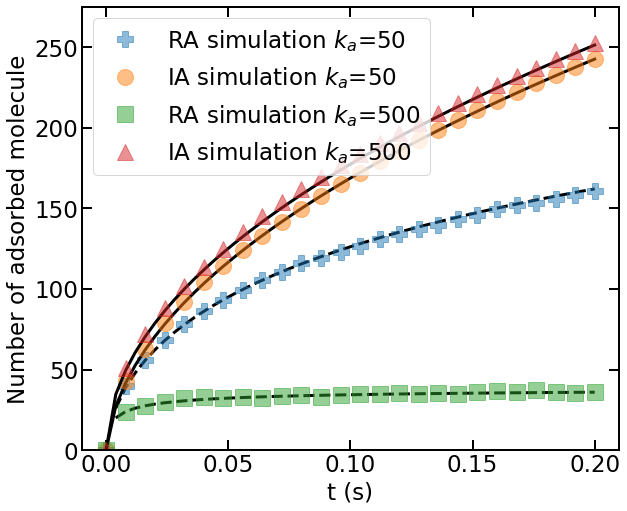

In [10]:
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
mks = ['P','o','s','^']
i=None
for kappa in [50.,500.]:
    if i==None:    i=0
    ka=kappa*D
    for kd in [ka*ka*0.1/4/D,0]:
        mk=mks[i]
        i+=1
        print('ka={},kd={},Pa={}'.format(ka,kd,sqrt(2./3)*ka*rm*2))
        name = '/home/chew/outputdata/2ndpaper/adsoprtion_timeseries_ka={}kd={}'.format(ka,kd)
        T,Nav = np.loadtxt(name,delimiter=',')    
        Nsa = NA-Nav
        h = kappa
        conc = NA/VOL
        wic = 'RA'
        if kd==0: wic='IA'
        ds=2
        if kd!=0:        
            ax.plot(T,2*conc*area*rev(ka,kd,T,D),'k--',linewidth=lw)
        else:
            ax.plot(T,2*conc*area*ST(ka,D,T)/kappa,'k-',linewidth=lw)
        ax.plot(T[::ds],Nsa[::ds],marker=mk,linestyle=' ',label='{} simulation $k_a$={:.0f}'.format(wic,ka),markersize=ms,alpha=0.5)   
ax.set_ylim(0,conc*1.1)
ax.set_ylabel('Number of adsorbed molecule',fontsize=fs)
ax.set_xlabel('t (s)',fontsize=fs)
ax.legend(loc='best',fontsize=fs)#,frameon=False)     
#ax.legend(fontsize=fs,loc='center right', bbox_to_anchor=(1, 0.6),frameon=0)
ax.tick_params(labelsize=fs)    
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both',which='both',direction='in',length=10,width=2)
plt.savefig("/home/chew/ecellwork/figure/2ndpaper/fig3a",format='pdf',dpi=800)           

conc 250.0
bins 29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


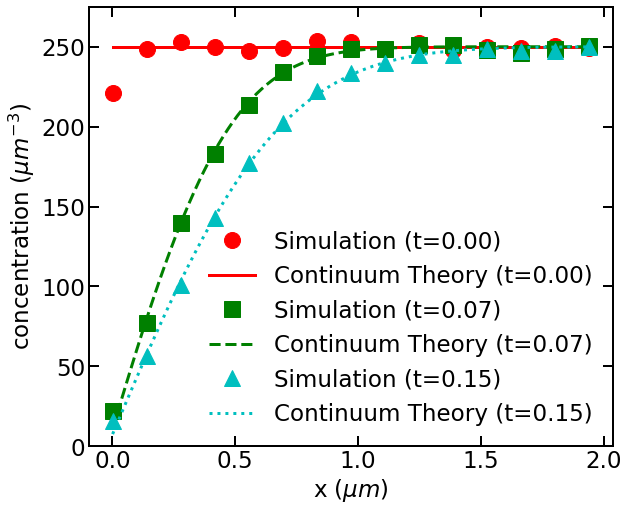

In [7]:
kappa = 50
ka=kappa*D
simrun=500

fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
conc=NA/VOL
print('conc',conc)
bins = 29
print('bins',bins)
clrs=['r','g','c']
tt=[0.0, 0.075, 0.15]
mks = ['o','s','^']
lss = ['-','--','dotted']

for i,t in enumerate(tt):#time loop
    c=clrs[i]
    mk=mks[i]
    ls=lss[i]
    name = '/home/chew/outputdata/2ndpaper/profile{}'.format(t)
    X = np.loadtxt(name)    
    fq,be = np.histogram(X,bins=bins)#,range=(0,LL))
    mp = (be[1:]+be[:-1])*0.5
    width = be[1]-be[0]
    vol=L*L*width    
    fq=fq/simrun/vol
    idx = mp>=2
    mp=mp[idx]-2
    fq=fq[idx]
    ax.plot(mp,fq,marker=mk,c=c,linestyle=' ',label='Simulation (t={:.2f})'.format(t),markersize=ms)
    smoothx = np.linspace(1e-3,mp[-1],100)
    pp = conc*(1-spaprofile(ka,D,smoothx,t)) #continuum spatial profile
    ax.plot(smoothx,pp,c=c,linestyle=ls,linewidth=lw,label='Continuum Theory (t={:.2f})'.format(t))
ax.set_ylim(0,conc*1.1)
ax.set_ylabel('concentration ($\\mu m^{-3}$)',fontsize=fs)
ax.set_xlabel('x ($\\mu m$)',fontsize=fs)
ax.legend(loc='best',fontsize=fs,frameon=False)  
ax.tick_params(labelsize=fs)    
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both',which='both',direction='in',length=10,width=2)
plt.savefig("/home/chew/ecellwork/figure/2ndpaper/fig3b",format='pdf',dpi=800)    
